## Preparation

In [8]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models.detection import faster_rcnn, fasterrcnn_resnet50_fpn_v2

import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using {device}')

# Basic parameters
syn_w = 750
syn_h = 1000
batch_size = 4
train_ratio = 0.9
data_num = 1000
num_classes = 3
num_classes_char = 6000
max_object_line = 50
max_object_char = 30
object_size_range = (12, 32)
base_num_epochs = 0
num_epochs = 100
learning_rate = 0.0001

# For random layout
random_layout_ratio = 0.5
object_min_x_space = 20
object_min_y_space = 40
object_line_range = (10, max_object_line)
blank_prob = 0.1
default_vertical_ratio = 0.8
random_vertical_ratio = True

# For augmentation
transform = True
intensity_shift_threshold = 128
intensity_shift_range = (-100, 100)
line_noise_range = (200, 255)
max_base_noise_amount = 20
max_line_noise_ratio = 0.1
max_white_noise_ratio = 0.1
max_sp_noise_ratio = 0.05
gaussian_kernel_size = 3
gaussian_sigma = (0.1, 1.0)

# For icon overlay
with_icon = True
max_icon_num = 20
overlap_retry = 40
icon_size_range = (10, 100)

# Paths
dataset_path = '../data/train_6k'
icon_path = '../data/source/Icons-50.npy'
model_path_load = f'../models/frcnnv2_det_line_{max_object_line}_{base_num_epochs}.pth'
model_path_save = f'../models/frcnnv2_det_line_{max_object_line}_{base_num_epochs+num_epochs}.pth'

Using cpu


## Dataset

In [10]:
icon_images = np.load(icon_path, allow_pickle=True).item()['image']
images_reshaped = icon_images.transpose(0, 2, 3, 1)
icon_images = np.dot(images_reshaped[...,:3], [0.2989, 0.5870, 0.1140])
print(icon_images.shape)

def add_icon(output_image, w=syn_w, h=syn_h):
    for _ in range(random.randint(0, max_icon_num)):
        icon_image = random.choice(icon_images)
        icon_w = random.randint(icon_size_range[0], icon_size_range[1])
        icon_h = random.randint(icon_size_range[0], icon_size_range[1])
        icon_image = Image.fromarray(icon_image).resize((icon_w, icon_h))
        icon_image = np.array(icon_image)

        for _ in range(overlap_retry):
            # Random position within the output image
            x = random.randint(0, w - icon_w)
            y = random.randint(0, h - icon_h)

            # Check for overlap with existing objects
            if np.all(output_image[y:y+icon_h, x:x+icon_w] == 255):
                # Place object image in the output image
                output_image[y:y+icon_h, x:x+icon_w] = icon_image
                break

(10000, 32, 32)


In [11]:
def create_synthetic_image_line(object_images, obj_w, obj_h, blank_prob=blank_prob):
    num_objects = len(object_images)
    is_last_blank = False
    vertical_probability = random.random() if random_vertical_ratio else default_vertical_ratio

    # Output vertical line
    if random.random() < vertical_probability or num_objects == 1:
        output_image = np.full((obj_h*num_objects, obj_w), 255, dtype=np.uint8)
        y_pos = 0
        label = 1
        for obj_image in object_images:
            if random.random() > blank_prob or y_pos == 0 or y_pos == obj_h*(num_objects-1) or is_last_blank:
                output_image[y_pos:y_pos+obj_h, 0:obj_w] = np.array(obj_image)
                is_last_blank = False
            else:
                is_last_blank = True
            y_pos += obj_h

    # Output horizontal line
    else:
        output_image = np.full((obj_h, obj_w*num_objects), 255, dtype=np.uint8)
        x_pos = 0
        label = 2
        for obj_image in object_images:
            if random.random() > blank_prob or x_pos == 0 or x_pos == obj_w*(num_objects-1) or is_last_blank:
                output_image[0:obj_h, x_pos:x_pos+obj_w] = np.array(obj_image)
                is_last_blank = False
            else:
                is_last_blank = True
            x_pos += obj_w

    return output_image, label

def create_synthetic_image_random(object_images, object_labels, w=syn_w, h=syn_h):
    output_image = np.full((h, w), 255, dtype=np.uint8)
    target_boxes = []
    box_labels = []

    # Place object images randomly without overlapping
    for obj_image, obj_label in zip(object_images, object_labels):
        obj_w, obj_h = obj_image.shape[1], obj_image.shape[0]
        if obj_w > w or obj_h > h:
            continue

        for _ in range(overlap_retry):
            # Random position within the output image
            x = random.randint(0, w - obj_w)
            y = random.randint(0, h - obj_h)

            # Check for overlap with existing objects
            if np.all(output_image[max(0, y-object_min_y_space):min(h, y+obj_h+object_min_y_space), max(0, x-object_min_x_space):min(w, x+obj_w+object_min_x_space)] == 255):
                # Place object image in the output image
                output_image[y:y+obj_h, x:x+obj_w] = obj_image

                # Store bounding box coordinates
                target_boxes.append([x, y, x+obj_w, y+obj_h])
                box_labels.append(obj_label)
                break

    if with_icon:
        add_icon(output_image)

    target = {
        'boxes': torch.tensor(target_boxes, dtype=torch.float32),
        'labels': torch.tensor(box_labels, dtype=torch.int64)
    }

    return torch.from_numpy(output_image).unsqueeze(0).float(), target

def create_synthetic_image_common(object_images, w=syn_w, h=syn_h, margin=80, margin_bias=20):
    output_image = np.full((h, w), 255, dtype=np.uint8)
    target_boxes = []
    box_labels = []

    char_stride_y = int(np.mean([obj.size[1] for obj in object_images]))
    char_stride_x = char_stride_y * 2

    margin_bias_x = random.randint(-margin_bias, margin_bias)
    margin_bias_y = random.randint(-margin_bias, margin_bias)

    position_x = [margin + margin_bias_x + i * char_stride_x for i in range(0, (w - margin*2) // char_stride_x + 1)]
    position_y = [margin + margin_bias_y + i * char_stride_y for i in range(0, (h - margin*2) // char_stride_y + 1)]

    if len(position_x) > max_object_line//2:
        position_x = random.sample(position_x, max_object_line//2)

    # Fixed positions for the objects
    positions = []
    grouped_objects = {}
    center_y = h // 2
    for x in position_x:
        random_y_1 = random.randint(0, h)
        random_y_2 = center_y + random.randint(0, h)
        grouped_objects[(x, min(position_y))] = 0
        grouped_objects[(x, next((y for y in position_y if y > center_y + char_stride_y)))] = 0
        for y in position_y:
            if y < center_y - char_stride_y and y < random_y_1:
                positions.append((x, y))
                grouped_objects[(x, min(position_y))] += 1
            elif y > center_y + char_stride_y and y < random_y_2:
                positions.append((x, y))
                grouped_objects[(x, next((y for y in position_y if y > center_y + char_stride_y)))] += 1

    # Place object images in fixed positions
    for obj_image, (x, y) in zip(object_images, positions):
        obj_w, obj_h = obj_image.size

        # Place object image in the output image
        output_image[y:y+obj_h, x:x+obj_w] = np.array(obj_image)

    # Store bounding box coordinates for grouped objects
    for (x, y), count in grouped_objects.items():
        if count > 0:
            obj_w, obj_h = object_images[0].size
            target_boxes.append([x, y, x+obj_w, y+obj_h*count])
            box_labels.append(1)

    if with_icon:
        add_icon(output_image)

    target = {
        'boxes': torch.tensor(target_boxes, dtype=torch.float32),
        'labels': torch.tensor(box_labels, dtype=torch.int64)
    }

    return torch.from_numpy(output_image).unsqueeze(0).float(), target

In [12]:
class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.data_num = data_num
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        font_num = len(self.image_files) // num_classes_char
        if random.random() < random_layout_ratio:
            # Random layout
            object_images_line = []
            object_labels_line = []

            for _ in range(random.randint(object_line_range[0], object_line_range[1])):
                # Randomly select a subset of object images
                num_objects_char = random.randint(1, max_object_char)
                char_indices = random.sample(range(num_classes_char), num_objects_char)
                font_index = random.randint(0, font_num-1)
                # Load and resize the object images randomly
                object_image_names = [str(char_index) + '_' + str(font_index) + '.jpg' for char_index in char_indices]
                new_object_size = random.randint(object_size_range[0], object_size_range[1])
                object_images_char = [Image.open(os.path.join(self.root_dir, image_name)).resize((new_object_size, new_object_size)) for image_name in object_image_names]
                # Create a synthetic image with labels
                image, label = create_synthetic_image_line(object_images_char, new_object_size, new_object_size)
                object_images_line.append(image)
                object_labels_line.append(label)

            image, label = create_synthetic_image_random(object_images_line, object_labels_line)

        else:
            # Common layout
            char_indices = random.sample(range(num_classes_char), 2000)
            font_index = random.randint(0, font_num-1)
            object_image_names = [str(char_index) + '_' + str(font_index) + '.jpg' for char_index in char_indices]
            new_object_size = random.randint(object_size_range[0], object_size_range[1])
            object_images_char = [Image.open(os.path.join(self.root_dir, image_name)).resize((new_object_size, new_object_size)) for image_name in object_image_names]
            image, label = create_synthetic_image_common(object_images_char)

        if transform:
            # Randomly add line noise to the tensor
            noise_probability_horizontal = random.uniform(0, max_line_noise_ratio)
            noise_probability_vertical = random.uniform(0, max_line_noise_ratio)
            height, width = image.shape[1], image.shape[2]
            for i in range(height):
                if random.random() < noise_probability_horizontal:
                    line_start = random.randint(0, width-1)
                    line_end = random.randint(0, width-1)
                    if line_start > line_end:
                        line_start, line_end = line_end, line_start
                    image[:, i, line_start:line_end] = random.randint(line_noise_range[0], line_noise_range[1])
            for i in range(width):
                if random.random() < noise_probability_vertical:
                    line_start = random.randint(0, height-1)
                    line_end = random.randint(0, height-1)
                    if line_start > line_end:
                        line_start, line_end = line_end, line_start
                    image[:, line_start:line_end, i] = random.randint(line_noise_range[0], line_noise_range[1])

            # Randomly add white noise to the tensor
            white_mask = torch.rand_like(image)
            noise_probability = random.uniform(0, max_white_noise_ratio)
            image = torch.where(white_mask < noise_probability, 255, image)

            # Randomly shift the tensor values
            shift_amount = random.randint(intensity_shift_range[0], intensity_shift_range[1])
            image[image < intensity_shift_threshold] += shift_amount
            image = torch.clamp(image, 0, 255)

            # Randomly add base noise to the tensor
            noise_amount = random.randint(0, max_base_noise_amount)
            if noise_amount > 0:
                image += torch.randint_like(image, -noise_amount, noise_amount)
            image = torch.clamp(image, 0, 255)

            # Randomly add salt and pepper noise to the tensor
            salt_pepper_mask = torch.rand_like(image)
            random_array = torch.randint_like(image, 0, 256)
            noise_probability = random.uniform(0, max_sp_noise_ratio)
            image = torch.where(salt_pepper_mask < noise_probability, random_array, image)

            # Randomly blur the tensor
            image = transforms.GaussianBlur(kernel_size=gaussian_kernel_size, sigma=gaussian_sigma)(image)

        return image, label

# Create a dataset using ImageFolder with custom transformation
dataset = CustomDataset(root_dir=dataset_path)

In [13]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# Split dataset into training and validation sets
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

27 29 44 27 

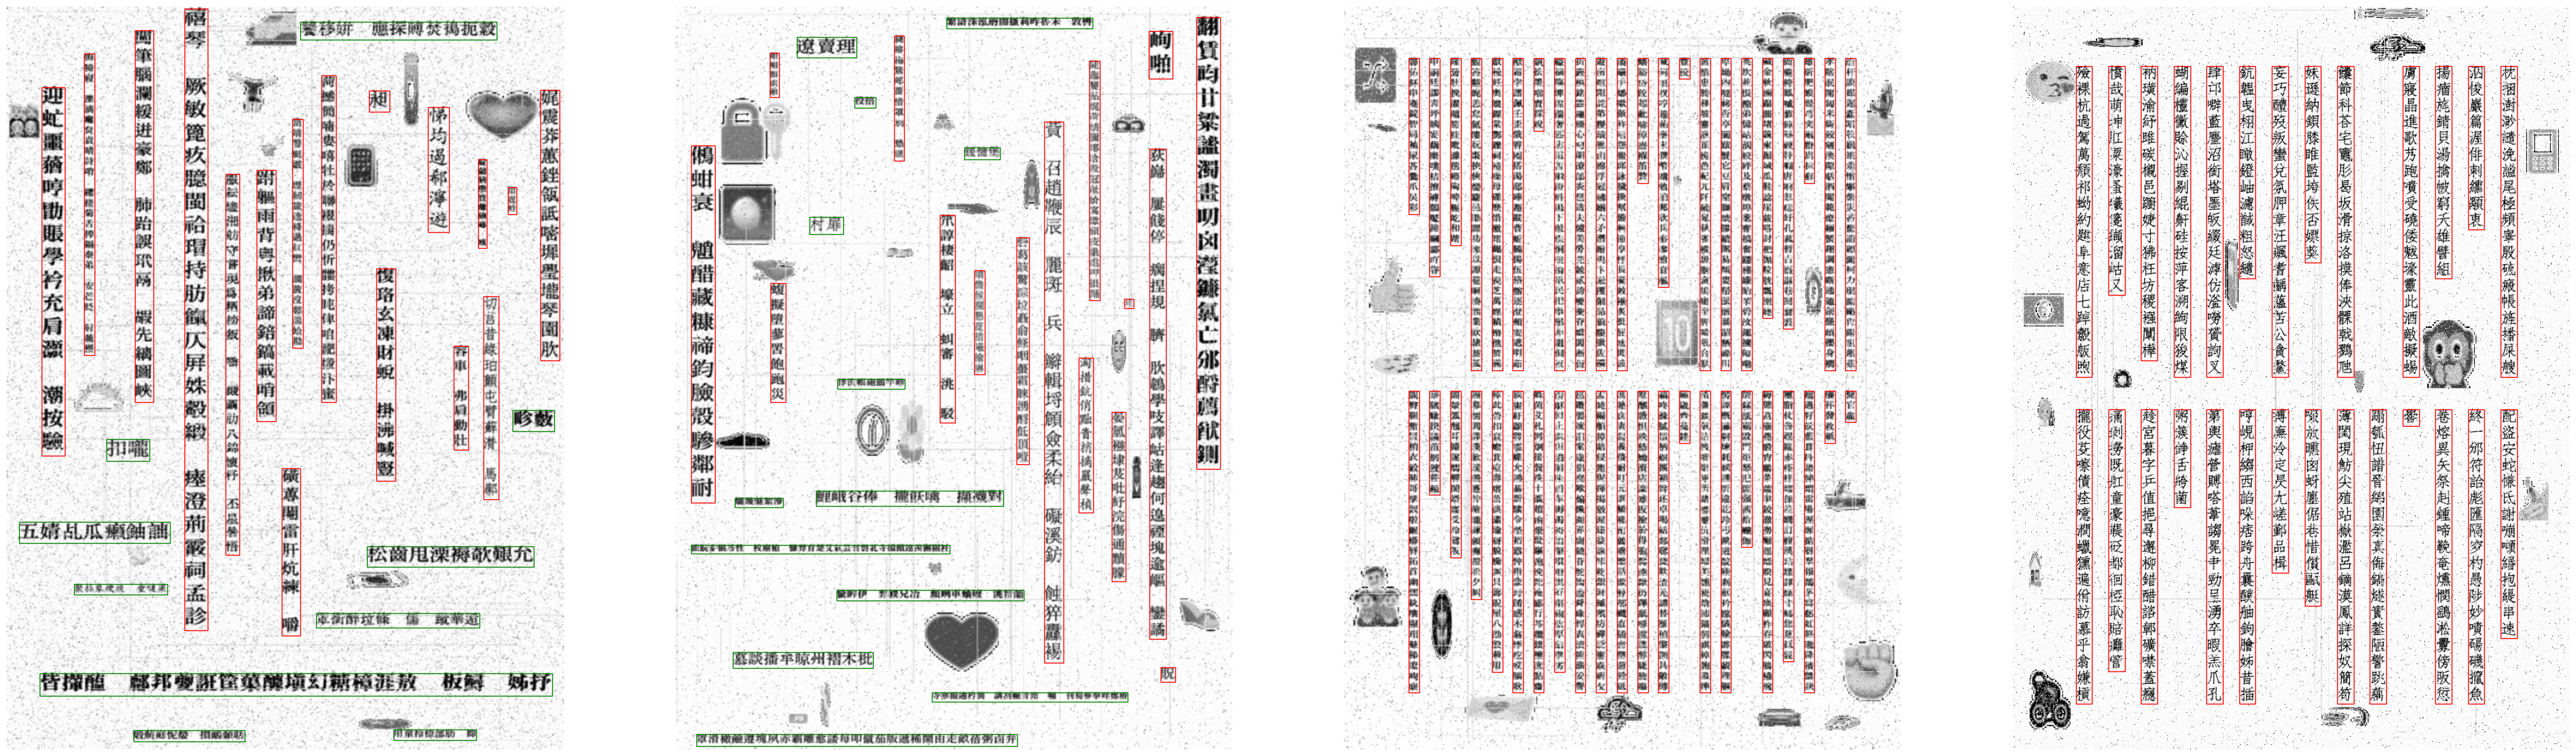

In [14]:
# Define a function to show images
def show_images(images, labels=None):
    fig, axes = plt.subplots(1, len(images), figsize=(50, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
        if labels is not None:
            print(len(labels[i]['boxes']), end=' ')
            for j in range(len(labels[i]['boxes'])):
                x_min, y_min, x_max, y_max = labels[i]['boxes'][j]
                label = labels[i]['labels'][j].item()
                width = x_max - x_min
                height = y_max - y_min
                box_color = 'r' if label == 1 else 'g'
                rect = Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=box_color, facecolor='none')
                ax.add_patch(rect)
    plt.show()

# Extract the first batch
batch_images, batch_labels = next(iter(train_loader))
show_images(batch_images, batch_labels)

## Train Model

In [ ]:
# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT', box_detections_per_img=max_object_line)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model = model.to(device)

if base_num_epochs != 0:
    state_dict = torch.load(model_path_load) if torch.cuda.is_available() else torch.load(model_path_load, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    print("Load model:", model_path_load)

# Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0005)

In [ ]:
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for images, targets in tepoch:
            tepoch.set_description(f'Epoch {epoch + 1}/{num_epochs} - Training')

            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            train_loss += losses.item()
            tepoch.set_postfix(loss=losses.item())

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation', unit="batch"):
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())

            val_loss += losses.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if (epoch + 1) % 5 == 0:
        try:
            torch.save(model.state_dict(), f'Models/frcnnv2_det_line_{max_object_line}_{base_num_epochs+epoch+1}.pth')
        except:
            print("Error saving model")

## Inference

In [ ]:
# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT', box_detections_per_img=max_object_line)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = faster_rcnn.FastRCNNPredictor(in_features, num_classes)
state_dict = torch.load(model_path_save) if torch.cuda.is_available() else torch.load(model_path_save, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device).eval()
print("Load model:", model_path_save)

### Predict on validation set

In [ ]:
# Extract the first batch
model.eval()
batch_images, batch_labels = next(iter(val_loader))
images = [image.to(device) for image in batch_images]
predictions = model(images)

In [ ]:
# Define a function to show prediction result
def show_predictions(images, predictions, labels, detection_threshold=0):
    fig, axes = plt.subplots(1, len(images), figsize=(50, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
        if predictions is not None:
            print("Prediction:", len(predictions[i]['boxes']), "True:", len(labels[i]['boxes']))
            for j in range(len(predictions[i]['boxes'])):
                x_min, y_min, x_max, y_max = predictions[i]['boxes'][j].cpu().detach().numpy()
                width = x_max - x_min
                height = y_max - y_min
                score = predictions[i]['scores'][j].item()
                label = predictions[i]['labels'][j].item()
                if score > detection_threshold:
                    alpha = (score-detection_threshold) / (1-detection_threshold)
                    rect = Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=(1, 0, 0, alpha), facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x_min+width, y_min, label, fontsize=10, color='r', verticalalignment='top')
    plt.show()

show_predictions(batch_images, predictions, batch_labels)

### Predict on sample image

In [ ]:
input_path = "target/samples/images/1.jpg"
input_image = np.array(Image.open(input_path).convert('L'))
input_image = torch.from_numpy(input_image).unsqueeze(0).unsqueeze(0).float().to(device)
prediction = model(input_image)

In [ ]:
def show_prediction(image, prediction, detection_threshold=0):
    fig, ax = plt.subplots(1, figsize=(15, 20))
    ax.imshow(image.squeeze().cpu(), cmap='gray')
    ax.axis('off')
    prediction = prediction[0]
    if prediction is not None:
        print(len(prediction['boxes']))
        for j in range(len(prediction['boxes'])):
            x_min, y_min, x_max, y_max = prediction['boxes'][j].cpu().detach().numpy()
            width = x_max - x_min
            height = y_max - y_min
            score = prediction['scores'][j].item()
            label = prediction['labels'][j].item()
            if score > detection_threshold:
                #alpha = (score - detection_threshold) / (1 - detection_threshold)
                color = (1, 0, 0) if label == 1 else (0, 1, 0)
                rect = Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
    plt.show()

show_prediction(input_image, prediction)